# COGS 108 - EDA Checkpoint

# Names

- Anna Wang
- Chloe Salem
- Kristy Liou
- Maxtierney Arias
- Zeven Vidmar Barker

<a id='research_question'></a>
# Research Question

Can we predict which state in the USA will be covid-free first based on current hospital records, state regulations, and population?

# Setup

In [1]:
#importing needed libraries
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime

# reading data sets
population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
case_tracking = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')
state_code = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

# Data Cleaning

In [2]:
#pip install -U seaborn

**Part (1)**
First we cleaned the population dataset by all of the columns except for state and estimate 2020 population. Then for the case tracking and vaccination dataset, we removed all of the columns that did not have information regarding the hospitalization, vaccination, and covid cases records. From the case tracking dataset, we removed the columns regarding the death counts. For the vaccination dataset, we removed forms of counting vaccinations we would not need.

In [3]:
# Removed unnecessary columns in Population dataframe
population = population[5::]
population = population[['NAME', 'POPESTIMATE2020']]
population.rename(columns={"NAME": "state", "POPESTIMATE2020": "2020 population"}, errors="raise", inplace=True)
#population.set_index(['NAME'], inplace=True)
#population.set_index(['NAME'], inplace=True)

population.head()

,state,2020 population
5,Alabama,4921532
6,Alaska,731158
7,Arizona,7421401
8,Arkansas,3030522
9,California,39368078


In [4]:
# Removed unnecessary columns in vaccinations and renamed for easier readability 
vaccinations = vaccinations.drop(['daily_vaccinations_per_million', 'share_doses_used', 'daily_vaccinations_per_million', 'share_doses_used'], 1)
new_names = []
for col in vaccinations.columns:
    new_names.append(col.replace('_', ' '))
vaccinations.rename(columns=dict(zip(vaccinations.columns, new_names)), inplace=True)

In [5]:
case_tracking.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

In [6]:
# Dropping more unrelated columns to research question - including deaths, antibody tests, negative results, and positive results related to type of test
case_tracking = case_tracking[['date', 'state', 'hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently', 'hospitalizedIncrease', 'positive', 'recovered', 'totalTestEncountersViralIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'positiveCasesViral', 'positiveIncrease']]
new_names = []
for name in case_tracking.columns:
    new_names.append((re.sub(r"(\w)([A-Z])", r"\1 \2", name)).lower())
case_tracking.rename(columns=dict(zip(case_tracking.columns, new_names)), inplace=True)

In [7]:
case_tracking.head()

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,recovered,total test encounters viral increase,total test results,total test results increase,positive cases viral,positive increase
0,2021-02-25,AK,1271.0,1271.0,45.0,11,55886.0,NaN,0,1671043.0,8887,NaN,150
1,2021-02-25,AL,45312.0,45312.0,722.0,62,491110.0,285130.0,0,2276188.0,7155,384640.0,890
2,2021-02-25,AR,14649.0,14649.0,522.0,0,318122.0,307978.0,0,2627733.0,9057,251299.0,726
3,2021-02-25,AS,NaN,NaN,NaN,0,0.0,NaN,0,2140.0,0,NaN,0
4,2021-02-25,AZ,57390.0,57390.0,1385.0,234,812907.0,NaN,0,7549777.0,37382,758177.0,939


In [8]:
vaccinations.head()

,date,location,total vaccinations,total distributed,people vaccinated,people fully vaccinated per hundred,total vaccinations per hundred,people fully vaccinated,people vaccinated per hundred,distributed per hundred,daily vaccinations raw,daily vaccinations
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.44,7.69,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.52,7.73,5906.0,5906.0
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.27,2.05,13488.0,1.77,9.07,8267.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0


**Part (2)**
After removing the unnecessary columns, we took a dataframe that contains information about the different identifies of state names and unabbreviated the case tracking dataset's state column in order to match the format of the vaccination dataset location column. Then we removed the information of the territories of the US in both dataset because we will only analyze US states. After cleaning the case tracking and vaccination dataset, we merge using a left join based off of the state and date variable to create one big dataset.

This new dataset will contain case tracking variables and vaccination variable for each corresponding state and date. Since vaccination data has only started in 1/3/2021, information regarding vaccination prior to that data will be null values.

In [9]:
# Converting case-tracker state from Abbreviation
for i,j in state_code.iterrows():
    state_code.loc[i]['Abbreviation']
    case_tracking.loc[case_tracking.state == state_code.loc[i]['Abbreviation'], ['state']] = state_code.loc[i]['State']

# Removing the US territory data from the datasets
territories = ['AS', 'GU', 'MP', 'VI', 'PR', 'American Samoa', 
               'Federated States of Micronesia', 'Indian Health Svc', 'Guam','Long Term Care',
               'Virgin Islands','Veterans Health', 'Republic of Palau','Puerto Rico', 'Bureau of Prisons',
             'Marshall Islands','Northern Mariana Islands','Dept of Defense','United States']
case_tracking = case_tracking[~case_tracking.state.isin(territories)]
vaccinations = vaccinations[~vaccinations.location.isin(territories)]
vaccinations.loc[vaccinations.location == 'New York State', ['location']] = 'New York'

# Checking if case_tracking and vaccinations have the same states
for i in case_tracking['state'].unique():
    if i not in vaccinations['location'].unique():
        print(i)
vaccinations.rename(columns={'location':'state'},inplace=True)

# Joining case_tracking and vaccination dataframes into one
merged_data = pd.merge(case_tracking, vaccinations, on = ['date', 'state'], how='left')

merged_data.head(-1)

,date,state,hospitalized,hospitalized cumulative,hospitalized currently,hospitalized increase,positive,recovered,total test encounters viral increase,total test results,...,total vaccinations,total distributed,people vaccinated,people fully vaccinated per hundred,total vaccinations per hundred,people fully vaccinated,people vaccinated per hundred,distributed per hundred,daily vaccinations raw,daily vaccinations
0,2021-02-25,Alaska,1271.0,1271.0,45.0,11,55886.0,NaN,0,1671043.0,...,249559.0,319265.0,158560.0,12.36,34.11,90416.0,21.68,43.64,5909.0,7201.0
1,2021-02-25,Alabama,45312.0,45312.0,722.0,62,491110.0,285130.0,0,2276188.0,...,864757.0,1170120.0,601343.0,5.34,17.64,261689.0,12.26,23.86,25054.0,27531.0
2,2021-02-25,Arkansas,14649.0,14649.0,522.0,0,318122.0,307978.0,0,2627733.0,...,572553.0,826130.0,384549.0,6.11,18.97,184346.0,12.74,27.38,18087.0,11688.0
3,2021-02-25,Arizona,57390.0,57390.0,1385.0,234,812907.0,NaN,0,7549777.0,...,1607544.0,2064265.0,1163157.0,6.02,22.09,438355.0,15.98,28.36,51602.0,57825.0
4,2021-02-25,California,NaN,NaN,6520.0,0,3460326.0,NaN,0,47814160.0,...,8064121.0,10956910.0,5746607.0,5.73,20.41,2263406.0,14.54,27.73,188110.0,223997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,2020-01-18,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18480,2020-01-17,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18481,2020-01-16,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18482,2020-01-15,Washington,NaN,NaN,NaN,0,0.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
merged_data.isna().sum()

date                                        0
state                                       0
hospitalized                             6206
hospitalized cumulative                  6206
hospitalized currently                   2285
hospitalized increase                       0
positive                                  181
recovered                                7946
total test encounters viral increase        0
total test results                        102
total test results increase                 0
positive cases viral                     6149
positive increase                           0
total vaccinations                      16394
total distributed                       16394
people vaccinated                       16404
people fully vaccinated per hundred     16456
total vaccinations per hundred          16394
people fully vaccinated                 16456
people vaccinated per hundred           16404
distributed per hundred                 16394
daily vaccinations raw            

# Data Analysis & Results (EDA)

**Part 1**
First we decided to analyze our population dataset by looking at the histogram and distribution plot.
From the results we see that more than half of US states have less than 10 million in population.

After we made a barplot that shows each state's population, where we can see which states have a larger population count.

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2020 population', ylabel='Count'>

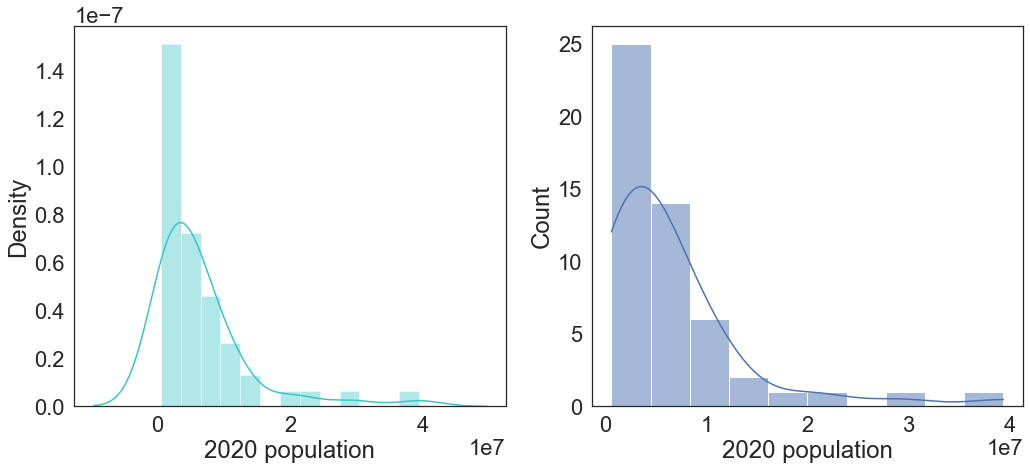

In [11]:
sns.set(style="white", font_scale=2)
plt.rcParams['figure.figsize'] = (17, 7)

plt.subplot(1, 2, 1)
sns.distplot(population['2020 population'], color='#3BC4C7');
plt.subplot(1, 2, 2)
sns.histplot(population['2020 population'], bins=10, kde=True)

<AxesSubplot:xlabel='2020 population', ylabel='state'>

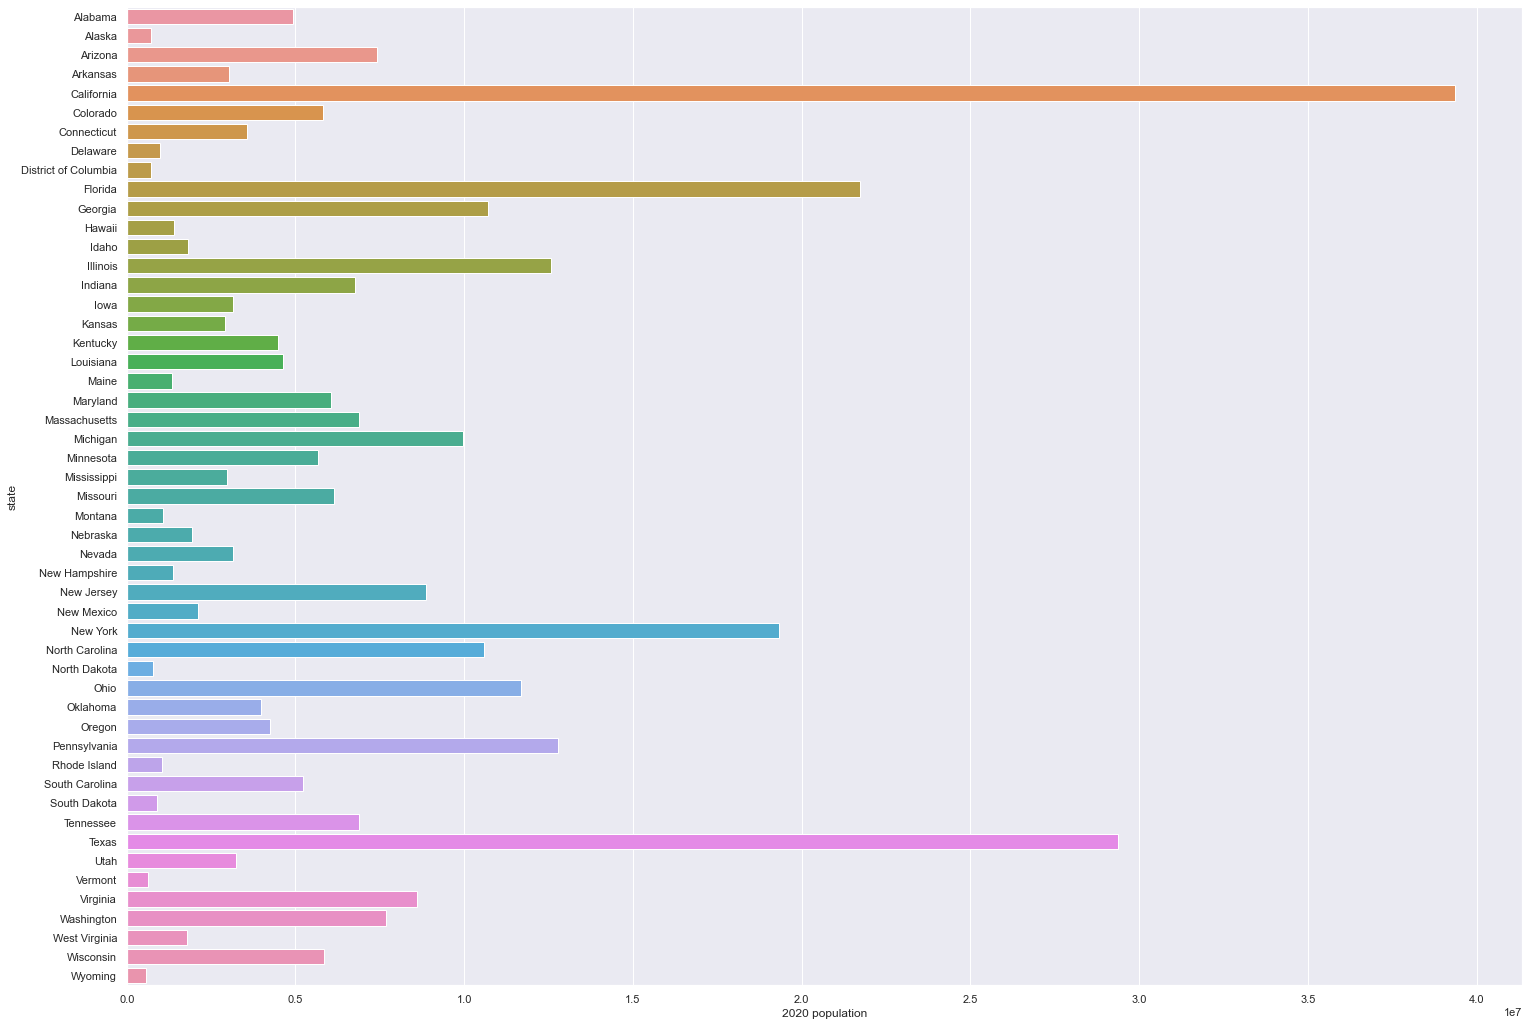

In [12]:
sns.set(rc={'figure.figsize':(25,18)})
sns.barplot(x=population['2020 population'], y='state', data=population)

**Part 2**
Next we decide to take the column `people vaccinated` to calculate the proportion of people vaccinated per state. When calculating the proportion, we used the most recent rows of each state and stored it in a seperate dataset called `most_recent`. After calulating the proportion and inserting the values in a new column `proportion vaccination`, we made a barplot, histogram, and distribution plot showing our results. 

From the barplot, we can compare the different proportion from each state. From the histogram and distribution graph, we can see how many states have similar vaccination proportion.

In [13]:
most_recent = merged_data[merged_data['date'] == '2021-02-23']
most_recent = pd.merge(most_recent, population, on = ['state'], how='left')
most_recent['proportion vaccination'] = most_recent['people vaccinated']/most_recent['2020 population']
most_recent['people vaccinated'].isnull().sum()

0

<AxesSubplot:xlabel='proportion vaccination', ylabel='state'>

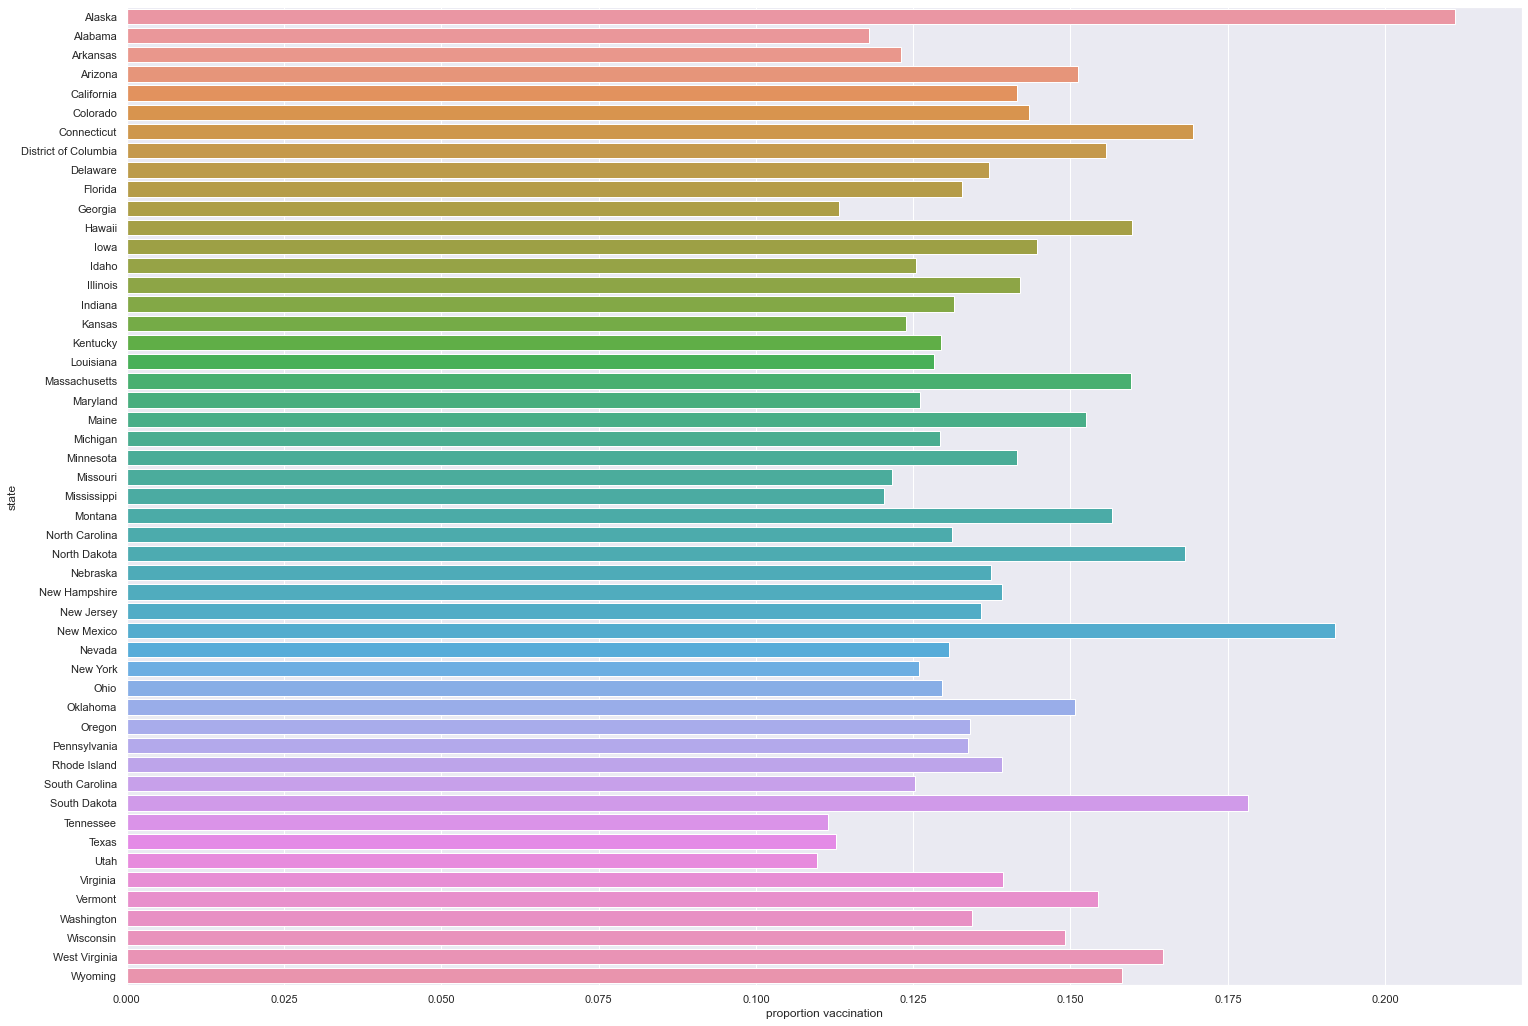

In [14]:
sns.set(rc={'figure.figsize':(25,18)})
sns.barplot(x=most_recent['proportion vaccination'], y='state', data=most_recent)

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='proportion vaccination', ylabel='Count'>

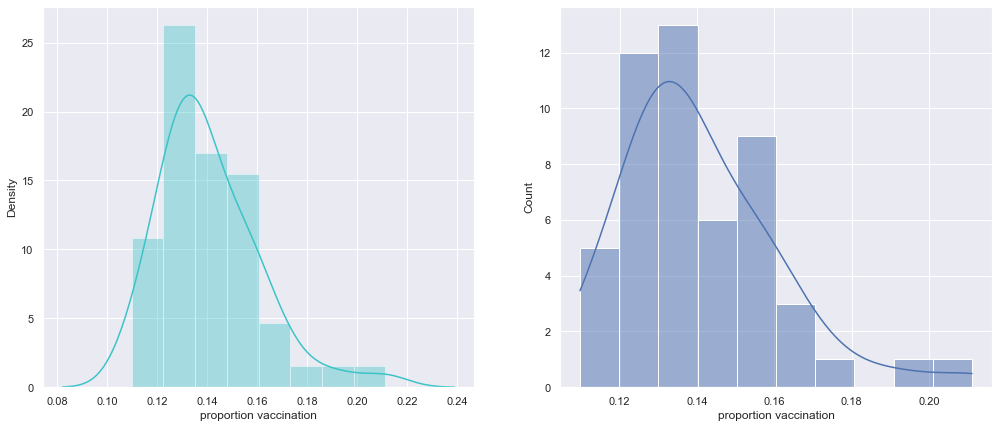

In [15]:
sns.set(rc={'figure.figsize':(17,7)})
plt.subplot(1, 2, 1)
sns.distplot(most_recent['proportion vaccination'], color='#3BC4C7');
plt.subplot(1, 2, 2)
sns.histplot(most_recent['proportion vaccination'], bins=10, kde=True)

We further decided to create a heat map of the proportion vaccination values within the US. This shown below, we can easily see state with a darker green color showing higher proportion values. This gives us an idea of the states that have a higher vaccination percentage with respect to their population.

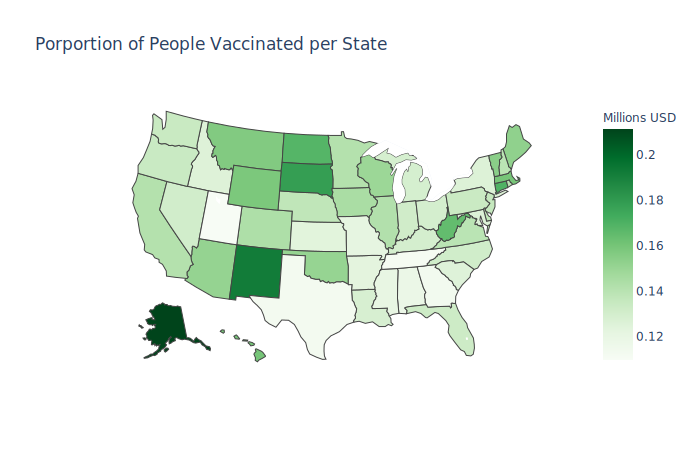

In [16]:
for i,j in state_code.iterrows():
    most_recent.loc[most_recent.state == state_code.loc[i]['State'], ['state']] = state_code.loc[i]['Abbreviation']


pio.renderers

fig = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion vaccination'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'Porportion of People Vaccinated per State',
    geo_scope='usa', # limite map scope to USA
)

fig.show(renderer="svg")

**Part 3**
Next we want to explore the hospitialization records across the US using the column `hospitalized currently`. First we created another heat map to display the current proportion of citizen hospitialized per state. We calculated the proportion and placed the result in a new column called `proportion hospitalized`. From this we can which states have higher percentage of hospitialized citizens.

In [17]:
most_recent['proportion increase'] = most_recent['positive increase']/most_recent['2020 population']
most_recent['proportion positive'] = most_recent['positive']/most_recent['2020 population']

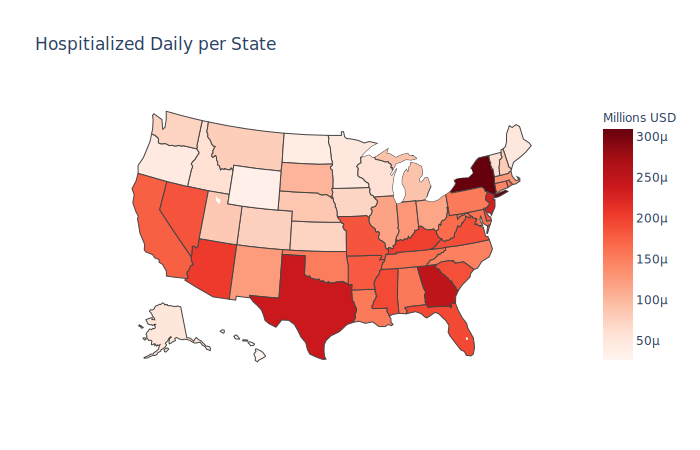

In [18]:
most_recent['proportion hospitalized'] = most_recent['hospitalized currently']/most_recent['2020 population']
fig2 = go.Figure(data=go.Choropleth(
    locations=most_recent['state'], # Spatial coordinates
    z = most_recent['proportion hospitalized'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig2.update_layout(
    title_text = 'Hospitialized Daily per State',
    geo_scope='usa', # limite map scope to USA
)

fig2.show(renderer="svg")

**Part 4**
Here we explored the hospital records and vaccination records of each state with a specific time frame. Since vaccination records started at the date 1/12/2021, we took the merged dataset and filted out the rows with the date before 1/12/2021. 

Since there are too many states to graph, we only looked at certain states like New York, Texas, and Utah. For each state we made two lineplots. One showing the trend of hosipitialization records based off of the current date. The other showing the number of daily vaccination based off of the current date.

From the graphs below we can see the different trends of hospital records and vaccination over 1 month. 

In [19]:
new_york_df = merged_data[merged_data['state'] == 'New York']
sns.set(rc={'figure.figsize':(25,7)})
new_york_df['date'] = pd.to_datetime(new_york_df['date'])
new_york_df2 = new_york_df[(new_york_df['date'] >= '2021-01-12')]
#new_york_df2['hospitalized'].isnull().sum()
#new_york_df2['daily vaccinations'].isnull().sum() = 1 for today's date

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in New York')]

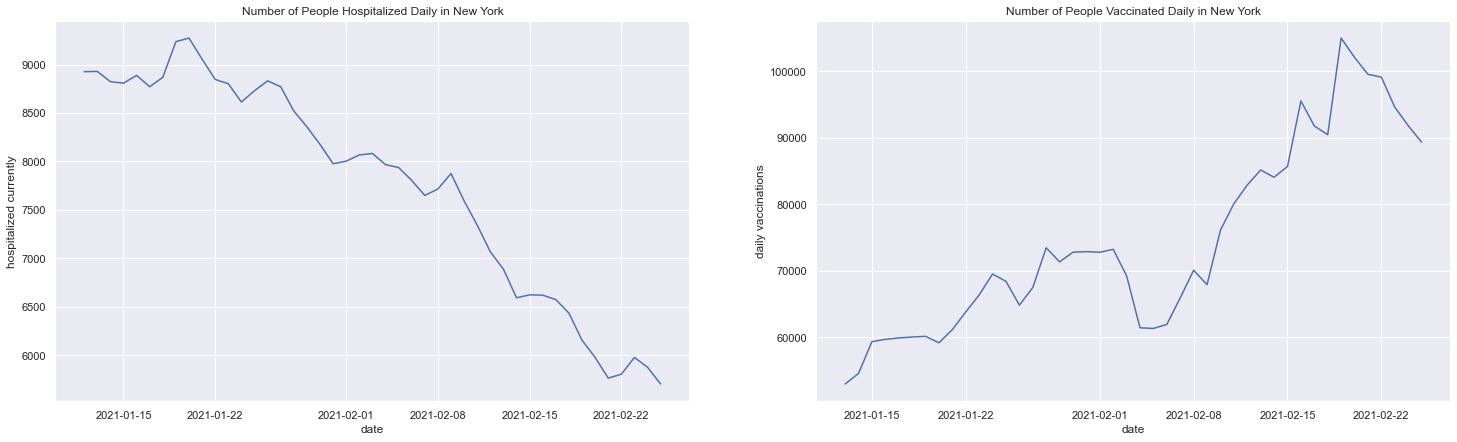

In [20]:
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=new_york_df2).set(title='Number of People Hospitalized Daily in New York')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='daily vaccinations', data=new_york_df2).set(title='Number of People Vaccinated Daily in New York')

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in Texas')]

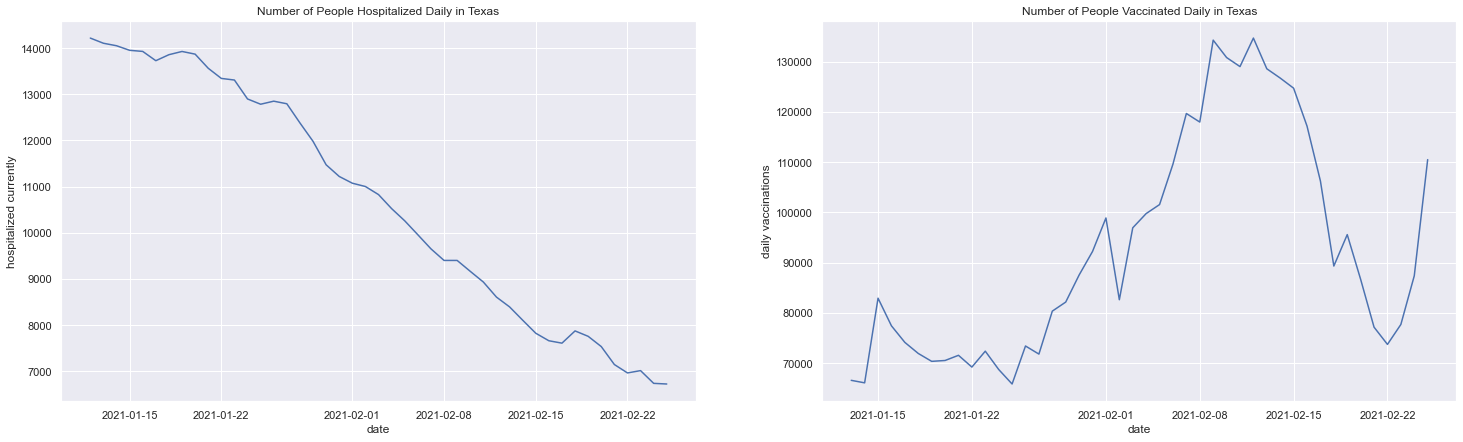

In [21]:
texas_df = merged_data[merged_data['state'] == 'Texas']
texas_df['date'] = pd.to_datetime(texas_df['date'])
texas_df = texas_df[(texas_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=texas_df).set(title='Number of People Hospitalized Daily in Texas')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='daily vaccinations', data=texas_df).set(title='Number of People Vaccinated Daily in Texas')

/Users/chloesalem/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 1.0, 'Number of People Vaccinated Daily in Utah')]

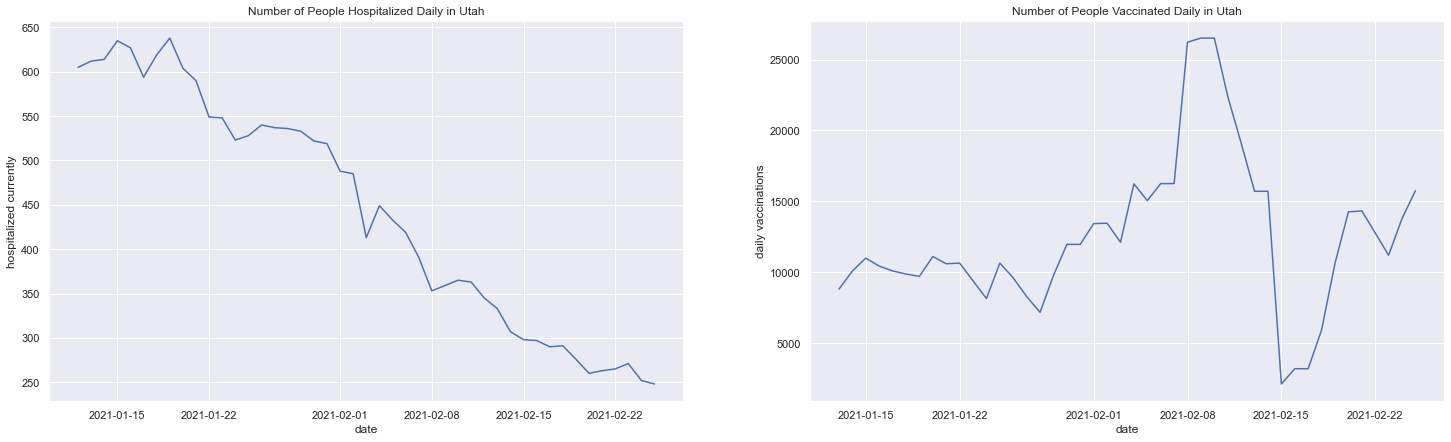

In [22]:
utah_df = merged_data[merged_data['state'] == 'Utah']
utah_df['date'] = pd.to_datetime(utah_df['date'])
utah_df = utah_df[(utah_df['date'] >= '2021-01-12')]
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='hospitalized currently', data=utah_df).set(title='Number of People Hospitalized Daily in Utah')
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='daily vaccinations', data=utah_df).set(title='Number of People Vaccinated Daily in Utah')

In [1]:
plt.subplot(1, 2, 1)  
sns.distplot(merged_data['people fully vaccinated'], color='#3BC4C7')
plt.subplot(1, 2, 2)
sns.distplot(merged_data['hospitalized currently'], color='#FF6699');

NameError: name 'plt' is not defined

In [2]:
sns.lmplot(x='2020 population', y='hospitalized currently', 
           data=most_recent, fit_reg=True);

NameError: name 'sns' is not defined